In [1]:
# imports
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import time
from pymc3.distributions.dist_math import normal_lcdf, normal_lccdf
import theano.tensor as tt


plt.rcParams["font.family"] = "Times New Roman"

In [2]:
data = pd.read_csv('test_data_hm3.txt')            # old simulated data
#data = pd.read_csv('test_data_no_cr_trunc.txt')   # simulated data where contrst ratios have not been truncated
#data = pd.read_csv('test_data_trunc.txt')         # new simulated data (return 'bad initial energy')
data[:3]

,Unnamed: 0,asep,asep_err,cr,cr_err,parallax,mass_ratios,psep
0,1,0.945307,0.07,1.100559,0.066415,0.023715,0.708909,39.861312
1,2,0.636065,0.07,1.517372,0.073234,0.021751,0.599299,29.242425
2,3,0.576794,0.07,0.315989,0.073665,0.017132,0.912471,33.668543


Fitting to a gaussian model of physical separations and a power law of mass ratio distributions.

There are two parameters to fit for separations, the center and width of the gaussian of physical projected separations (in AU)

In [3]:
# useful functions integrate censored data out through the likelihood
# from https://docs.pymc.io/notebooks/censored_data.html

def left_censored_likelihood(mu, sigma, n_left_censored, lower_bound):
    ''' Likelihood of left-censored data. '''
    return n_left_censored * normal_lcdf(mu, sigma, lower_bound)


def right_censored_likelihood(mu, sigma, n_right_censored, upper_bound):
    ''' Likelihood of right-censored data. '''
    return n_right_censored * normal_lccdf(mu, sigma, upper_bound)


def truncated_likelihood(name, mu, sigma, n_right_truncated, upper_bound=None, lower_bound=None):
    return n_right_truncated * pm.TruncatedNormal(name, mu, sigma, upper=upper_bound)

In [4]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_ang_max = 4.0


# limit for contrast ratio
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    return 1.8 * np.log(separation) + 3.8

# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

In [17]:
def pymc3_hrchl_fit(data, nsteps=1000):
    asep = data['asep'].values
    asep_err = data['asep_err'].values
    cr = data['cr'].values
    cr_err = data['cr_err'].values
    parallax = data['parallax'].values
    #mass_ratio_data = data['mass_ratios'].values
    #psep_data = data['psep'].values


    with pm.Model() as hierarchical_model:

        # PRIORS
        # -------------
        
        # Separations
        center = pm.Gamma('center', mu=40, sigma=10)
        # the Gamma distribution for separations should have 0 < width < center, 
        # because we're assuming that the peak is above 0 for separations
        width_diff = pm.Beta('width_difference', alpha=2, beta=2)
        width = pm.Deterministic('width', center-(center*width_diff))
        
        # power_index must be bound to work with the Kumaraswamy model
        p = pm.Gamma('p', mu=0.2, sigma=.5)
        power_index = pm.Deterministic('power_index', 1+p)
        
        
        # MODELS OF POPULATIONS PHYSICAL PROPERTIES
        # --------------
        
        # Gaussian model for separations (in AU)
        sep_physical = pm.Gamma('sep_physical', mu=center, sigma=width)
        
        # Mass Ratios - inverted
        mass_ratios_inverted = pm.Pareto('mass_ratios_inverted', alpha=power_index, m=1)
        
        
        # MAPPING FROM PHYSICAL TO OBSERVED PROPERTIES
        # ---------------

        #  physical separations to angular separations
        sep_angular = pm.Deterministic('sep_angular', sep_physical * parallax)
        
        # inverted mass ratios to inverted contrast ratios
        contrast_ratios_inverted = pm.Deterministic('contrast_ratios_inverted', imr_to_icr(mass_ratios_inverted))
        
        
        
        # LIKELIHOODS, WITH MEASUREMENT ERROR
        # -----------------
        
        # separations
        sep_observed = pm.TruncatedNormal('sep_observed', mu=sep_angular, sigma=asep_err, observed=asep, upper=sep_ang_max)
        
        # contrast ratios
        #cr_truncated = pm.TruncatedNormal('cr_truncated', mu=contrast_ratios_inverted, sigma=cr_err/cr, lower=1/cr_max(sep_observed))
        
        
        
        # RUNNING THE FIT
        # -------------------
        traces = pm.sample(tune=nsteps, draws=nsteps, step=None, chains=1)
        
        # output as dataframe
        df = pm.trace_to_dataframe(traces)
    return df

In [18]:
ta = time.time()
samples = pymc3_hrchl_fit(data, nsteps=1000)
tb = time.time()
print('Fit finished, took ',round((tb -ta)/60., 1),' minutes' )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mass_ratios_inverted, sep_physical, p, width_difference, center]
Sampling chain 0, 0 divergences:   5%|▎      | 99/2000 [00:02<00:49, 38.18it/s]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `mass_ratios_inverted_lowerbound__`.ravel()[0] is zero.
The derivative of RV `sep_physical_log__`.ravel()[0] is zero.
The derivative of RV `p_log__`.ravel()[0] is zero.
The derivative of RV `width_difference_logodds__`.ravel()[0] is zero.
The derivative of RV `center_log__`.ravel()[0] is zero.

In [16]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

p_lower, p, p_upper = q['power_index']

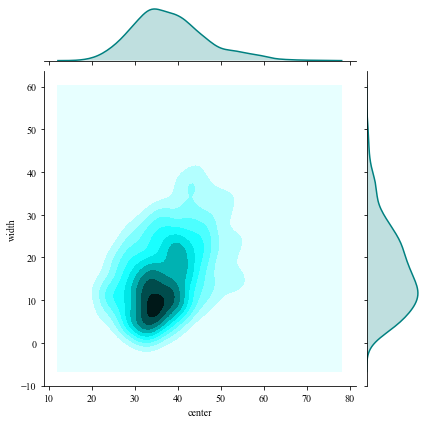

In [17]:
sns_plot = sns.jointplot(x='center', y='width', data=samples, kind='kde', color='teal');

#print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
#print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))
sns_plot.savefig("sep_pdf.png")

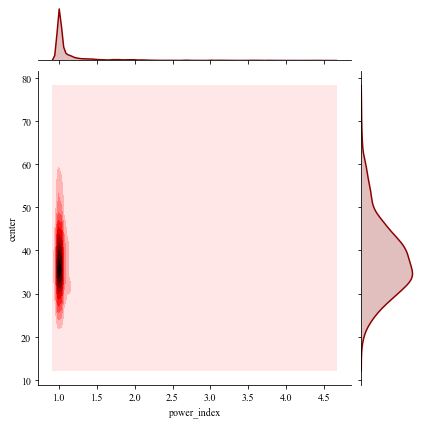

In [18]:
sns_plot = sns.jointplot(x='power_index', y='center', data=samples, kind='kde', color='darkred');


#print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
#print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))

sns_plot.savefig("pi_pdf.png")

## Comparing Results to Original Population

In [13]:
# functions to plot
import scipy.stats as st

def plot_gamma(mu, sigma, data, bins, label):
    a = mu**2 /sigma**2
    b = mu / sigma**2
    xs = np.linspace(0, np.max(data), 100)
    ys = st.gamma.pdf(xs, a, scale=1.0/b)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label)
    
def plot_power_law(index, data, bins, label):
    xs = np.linspace(0, np.max(data), 100)
    ys = index*xs**(index-1.)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label);

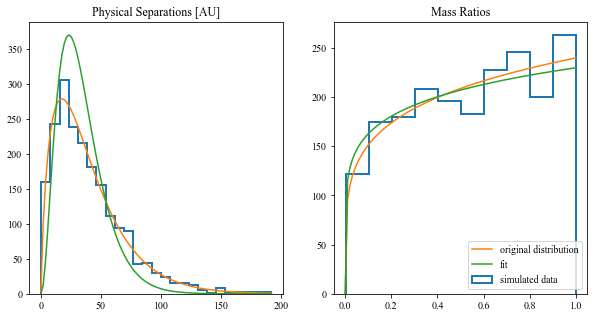

In [183]:
op = pd.read_csv('test_op0.txt')

fig = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Physical Separations [AU]')
count, bns, ignored = plt.hist(op['sep_physical'], histtype='step', label='simulated data', bins=25, linewidth=2)
plot_gamma(40, 30, op['sep_physical'], bns, 'original distribution')
plot_gamma(c, w, op['sep_physical'], bns, 'fit')
#plt.legend(loc='lower right');

plt.subplot(122)
plt.title('Mass Ratios')
count, bns, ignored = plt.hist(op['mass_ratio'], histtype='step', label='simulated data', bins=10, linewidth=2)
plot_power_law(1.2, op['mass_ratio'], bns, 'original distribution')
plot_power_law(p, op['mass_ratio'], bns, 'fit')
plt.legend(loc='lower right');

fig.savefig('model_fit.png', dpi=200)

Should be

Center: 40 <br>
Width: 30

Power Law index: 1.2

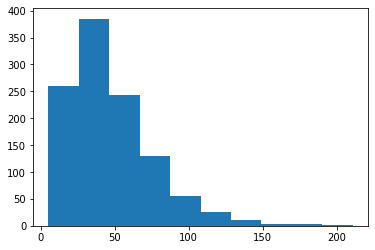

In [19]:
plt.hist(data['asep']/data['parallax']);

In [20]:
plt.hist(data['mass_ratios']);

KeyError: 'mass_ratios'

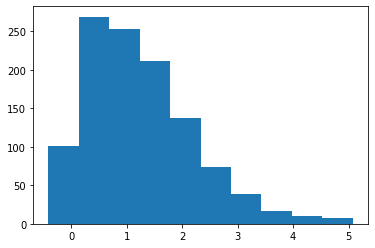

In [21]:
plt.hist(data['cr']);